# Hybrid model: linear reservoir
***

**Author:** Chus Casado Rodríguez<br>
**Date:** 06-09-2024<br>

* [x] Check the values of residence time ($T$) generated by the LSTM+dense layers.
* [x] Check if the model weights are equal across epochs, which would indicate that the model is not learning. <font color='blue'>They are the same indeed, so the model is not learning.</font>. **FIXED** There were two issues in `LinearReservoir.forward()`:
    * `torch.clamp()` does not do the same as `torch.min(torch.max())`
    * `eps = torch.tensor(..., requires_grad=True, ...)` 
* [ ] Check if the gradients are too small. The inflow/outflow values are very, very small, which could cause small gradients.
* [ ] ¿What's the effect of the <font color='blue'>**warmup period**</font>? Should it be only one day less than the sequence length?
* [ ] Test the best initial value for the initial fraction filled.
* [ ] Try the manual run with several basins in the test sample.
* [ ] Train on storage instead of outflow. Storage needs to be the only variable in `out` (`LinearReservoir.forward()`)
* [ ] Train on both storage and outflow. Storage needs to be added as the second variable in `out` (`LinearReservoir.forward()`)
* [ ] To clip or not to clip gradients?

The fitted residence time varies a lot (probably too much) with time!! Reduce the influence of dynamic inputs? Add static inputs that define the hydroclimatic charateristics of the basin.

In [12]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import pickle
from pathlib import Path
from tqdm import tqdm
from datetime import datetime

from neuralhydrology.utils.config import Config
from neuralhydrology.datasetzoo import get_dataset
from neuralhydrology.datautils.utils import load_scaler
from neuralhydrology.modelzoo import get_model
# from neuralhydrology.modelzoo.customlstm import CustomLSTM
# from neuralhydrology.modelzoo.cudalstm import CudaLSTM
#from neuralhydrology.modelzoo.hybridmodel import HybridModel
from neuralhydrology.training import get_loss_obj, get_regularization_obj#, get_optimizer
# from neuralhydrology.training.basetrainer import BaseTrainer
from neuralhydrology.nh_run import start_run
from neuralhydrology.training.train import start_training
from neuralhydrology.evaluation.evaluate import start_evaluation
from neuralhydrology.evaluation import get_tester

## Configuration

In [13]:
MODEL_PATH = Path('/eos/jeodpp/home/users/casadje/models/ResOpsES/hybrid_model/')

# run_dir = MODEL_PATH / 'linear_reservoir' / 'LinRes_ES3_Q_wu0_0609_121701'
run_dir = MODEL_PATH / 'linear_reservoir' / 'LinRes_ES3_Q_wu182_0609_115010'
# run_dir = MODEL_PATH / 'linear_reservoir' / 'LinRes_ES3_Q_wu364_0609_131319'

In [14]:
# read configuration file
cfg = Config(Path(run_dir / 'config.yml'))

# get the hybrid model: LSTM + LinearReservoir
model = get_model(cfg).to(cfg.device)
print(model)
print('device:', next(model.parameters()).device)

# # get the optimizer
# optimizer = get_optimizer(model, cfg)
# print(optimizer)

HybridModel(
  (embedding_net): InputLayer(
    (statics_embedding): Identity()
    (dynamics_embedding): Identity()
  )
  (lstm): LSTM(75, 256)
  (conceptual_model): LinearReservoir()
  (linear): Linear(in_features=256, out_features=1, bias=True)
)
device: cuda:0


In [15]:
# get the loss object
loss_obj = get_loss_obj(cfg)
loss_obj.set_regularization_terms(get_regularization_obj(cfg))
print(loss_obj)

MaskedNSELoss()


In [16]:
# # find directory of the last run
# # run_dir = sorted([d for d in cfg.run_dir.glob(f'{cfg.experiment_name}*') if d.is_dir()])[-1]
# run_dirs = {}
# year = str(datetime.now().year)
# for d in cfg.run_dir.glob(f'{cfg.experiment_name}*'):
#     if not d.is_dir():
#         continue
#     key = datetime.strptime(year + str(d)[-11:], '%Y%d%m_%H%M%S')
#     run_dirs[key] = d
# run_dir = run_dirs[max(run_dirs)]
# print('run directory:', run_dir, end='\n\n')

## Data

In [77]:
# load list of reservoirs
reservoirs = sorted(pd.read_csv(cfg.test_basin_file, header=None)[0].tolist())

# load attributes
attributes = pd.concat([pd.read_csv(file, index_col='GRAND_ID') for file in (cfg.data_dir / 'attributes').glob('*.csv')], 
                       axis=1,
                       join='outer')
attributes.index.name = 'id'
attributes = attributes.loc[reservoirs]#, cfg.static_attributes]

print('static attributes: {0} reservoirs, {1} attributes'.format(*attributes.shape))

static attributes: 130 reservoirs, 253 attributes


***

In [76]:
# # generate new CSV with missing attributes
# cols = attributes.columns.tolist()
# for file in (cfg.data_dir / 'attributes' / 'others').glob('*.csv'):
#     print(file)
#     df = pd.read_csv(file, index_col='GRAND_ID')
#     new_cols = df.columns.difference(cols)
#     if len(new_cols) > 0:
#         cols += new_cols.tolist()
#         df = df[new_cols]
#         aux[file.stem] = df
#         if df.shape[1] > 0:
#             df.to_csv(cfg.data_dir / 'attributes' / f'{file.stem}.csv')

/eos/jeodpp/home/users/casadje/data/ResOpsES/v3.0/attributes/others/cedex.csv
/eos/jeodpp/home/users/casadje/data/ResOpsES/v3.0/attributes/others/combined.csv
/eos/jeodpp/home/users/casadje/data/ResOpsES/v3.0/attributes/others/efas.csv
/eos/jeodpp/home/users/casadje/data/ResOpsES/v3.0/attributes/others/icold.csv
/eos/jeodpp/home/users/casadje/data/ResOpsES/v3.0/attributes/others/use.csv


***

In [79]:
# load time series
dynamic_vars = cfg.dynamic_inputs + cfg.dynamic_conceptual_inputs + cfg.target_variables + ['storage']
timeseries = {ID: xr.open_dataset(cfg.data_dir / 'time_series' / f'{ID}.nc').to_pandas()[dynamic_vars] for ID in reservoirs}
# trim time series to the test period
with open(cfg.per_basin_test_periods_file, 'rb') as file:
    periods = pickle.load(file)
periods = {ID: dct for ID, dct in periods.items() if int(ID) in reservoirs}
for ID, ts in timeseries.items():
    start, end = [periods[str(ID)][x][0] for x in ['start_dates', 'end_dates']]
    ts = ts.loc[start:end]

## Results from training

### Performance

In [80]:
perf_val = []
for epoch in range(1, cfg.epochs + 1):
    try:
        aux = pd.read_csv(run_dir / 'validation' / f'model_epoch{epoch:03}' / 'validation_metrics.csv',
                             index_col='basin').squeeze()
        aux.name = f'epoch{epoch:03}'
        perf_val.append(aux)
    except:
        break
perf_val = pd.concat(perf_val, axis=1)

In [81]:
perf_val.median(axis=0)

epoch001    0.328132
epoch002    0.209709
epoch003    0.331184
epoch004    0.331184
epoch005    0.337105
dtype: float64

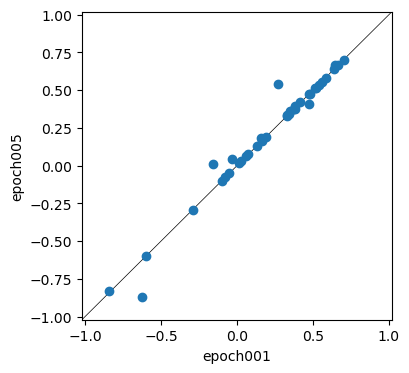

In [82]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.plot([-2, 2], [-2, 2], c='k', lw=.5, zorder=0)
ax.scatter(perf_val.iloc[:, 0], perf_val.iloc[:, -1])
ax.set(xlim=(-1.02, 1.02),
       ylim=(-1.02, 1.02),
       xlabel=perf_val.columns[0],
       ylabel=perf_val.columns[-1]);

### Analyse weights and biases

In [83]:
# load model states
weights = {}
for epoch in range(1, cfg.epochs + 1):
    try:
        weights[epoch] = torch.load(run_dir / f'model_epoch{epoch:03}.pt',)
    except:
        break

# check if weights are the same in the first and last epoch
par = 'lstm.bias_ih_l0' #'lstm.weight_ih_l0' # 'lstm.weight_hh_l0'
for par in weights[1].keys():
    if torch.allclose(weights[1][par], weights[3][par]): # cfg.epochs][par]):
        print(f'{par:<17} is the same in the first and last epoch')

<font color='indianred'>The model is not learning because the weights and biases are the same in the first and last epoch!!</font>

In [84]:
# load model states from the last epoch
model.load_state_dict(weights[cfg.epochs])

<All keys matched successfully>

#### LSTM

Parameter name: weight_ih_l0	shape: torch.Size([1024, 75])	device: cuda:0	requires_grad: True
Parameter name: weight_hh_l0	shape: torch.Size([1024, 256])	device: cuda:0	requires_grad: True
Parameter name: bias_ih_l0	shape: torch.Size([1024])	device: cuda:0	requires_grad: True
Parameter name: bias_hh_l0	shape: torch.Size([1024])	device: cuda:0	requires_grad: True


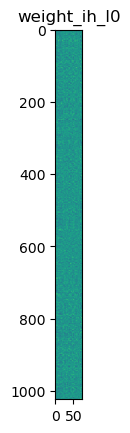

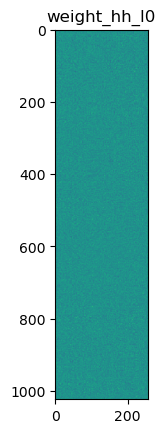

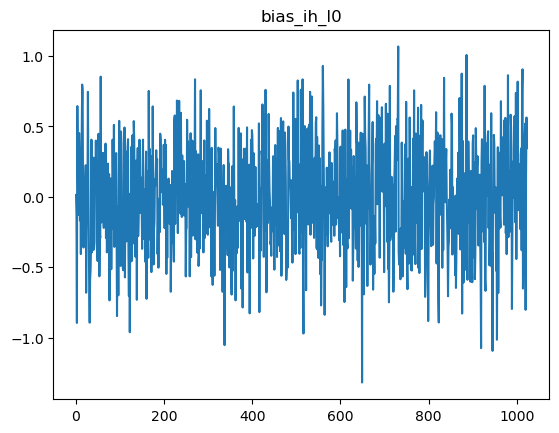

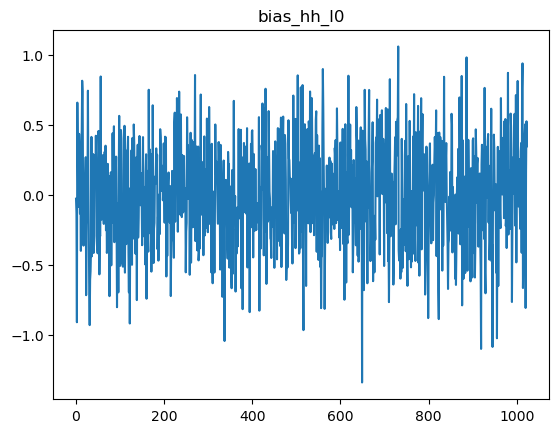

In [85]:
for name, param in model.lstm.named_parameters():
    print(f'Parameter name: {name}', end='\t')
    print(f'shape: {param.size()}', end='\t')
    print(f'device: {param.device}', end='\t')
    print(f'requires_grad: {param.requires_grad}')
    if len(param.shape) == 1:
        plt.figure()
        plt.plot(param.detach().cpu().numpy())
        plt.title(name)
    elif len(param.shape) == 2:
        plt.figure()
        plt.imshow(param.detach().cpu().numpy())
        plt.title(name)

#### Linear

Parameter name: weight	shape: torch.Size([1, 256])	device: cuda:0	requires_grad: True
Parameter name: bias	shape: torch.Size([1])	device: cuda:0	requires_grad: True
bias = -1.600


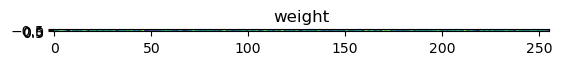

In [86]:
for name, param in model.linear.named_parameters():
    print(f'Parameter name: {name}', end='\t')
    print(f'shape: {param.size()}', end='\t')
    print(f'device: {param.device}', end='\t')
    print(f'requires_grad: {param.requires_grad}')
    if len(param.shape) == 1:
        print(f'bias = {param[0]:.3f}')
        # plt.figure()
        # plt.plot(param.detach().cpu().numpy())
        # plt.title(name)
    elif len(param.shape) == 2:
        plt.figure()
        plt.imshow(param.detach().cpu().numpy())
        plt.title(name)

## Results from test

### `test_results.p`

In [87]:
with open(run_dir / 'test' / f'model_epoch{cfg.epochs:03}' / 'test_results.p', 'rb') as file:
    results = pickle.load(file)

In [88]:
results['2649']['1D']['xr']#['y_hat'].shape

<xarray.Dataset>
Dimensions:           (date: 4960, time_step: 1)
Coordinates:
  * date              (date) datetime64[ns] 1990-01-01 1990-01-02 ... 2003-07-31
  * time_step         (time_step) int64 0
Data variables:
    outflow_norm_obs  (date, time_step) float32 0.02594 0.02513 ... 0.0 0.0
    outflow_norm_sim  (date, time_step) float32 nan nan ... 0.009146 0.007926

### `test_all_output.p`

In [89]:
with open(run_dir / 'test' / f'model_epoch{cfg.epochs:03}' / 'test_all_output.p', 'rb') as file:
    all_output = pickle.load(file)

In [90]:
all_output['2649']['y_hat'].shape

(4960, 183, 1)

It contains only the tensor put out by the hybrid model (`[days, seq_length - warmup, target]`)

### `test_metrics.csv`

In [91]:
metrics = pd.read_csv(run_dir / 'test' / f'model_epoch{cfg.epochs:03}' / 'test_metrics.csv', index_col='basin').squeeze()
metrics.index.name = 'id'
attributes = pd.concat((attributes, metrics), axis=1)

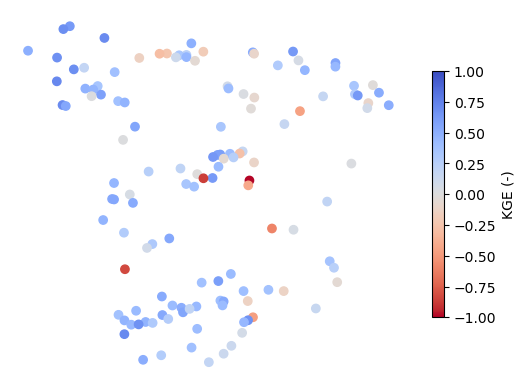

In [92]:
fig, ax = plt.subplots()
sct = ax.scatter(attributes.LON, attributes.LAT, c=attributes.KGE, vmin=-1, vmax=1, cmap='coolwarm_r')
ax.axis('off')
fig.colorbar(sct, shrink=.666, label='KGE (-)');

<Axes: xlabel='date'>

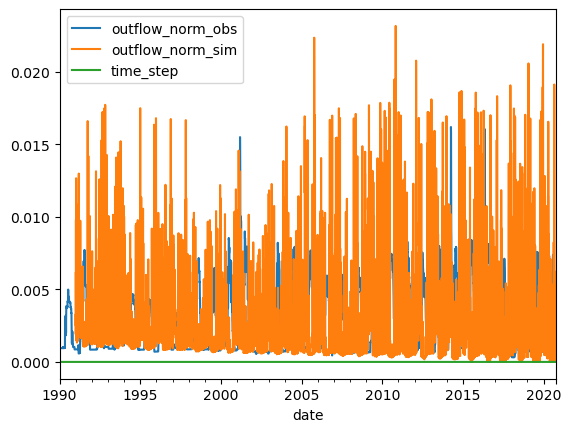

In [94]:
results['2666']['1D']['xr'].sel(time_step=0).to_pandas().plot()

## Evaluation

In [97]:
period = 'test'

In [98]:
# load test data
scaler = load_scaler(run_dir)
dataset = get_dataset(cfg,
                      is_train=False,
                      period=period,
                      scaler=scaler)
dataloader = DataLoader(dataset,
                        batch_size=1000,
                        shuffle=False,
                        collate_fn=dataset.collate_fn)

print(f'no. basins in the {period} period: {len(dataset.basins)}')

ValueError: Some basins are missing static attributes.

### "Manually"

#### Output

In [ ]:
# # set model in evaluation mode
# model.eval()

# save_all_output = True
# frequencies = dataset.frequencies
# predict_last_n = cfg.predict_last_n
# if isinstance(predict_last_n, int):
#     predict_last_n = {frequencies[0]: predict_last_n}

# from typing import Dict

# def _subset_targets(
#     # model: BaseModel,
#     data: Dict[str, torch.Tensor],
#     predictions: np.ndarray,
#     predict_last_n: np.ndarray,
#     freq: str
# ):
#     """Subset the last n values in both observed and predicted target variables"""
#     y_hat_sub = predictions[f'y_hat{freq}'][:, -predict_last_n:, :]
#     y_sub = data[f'y{freq}'][:, -predict_last_n:, :]
    
#     return y_hat_sub, y_sub

# preds, obs, dates, all_output = {}, {}, {}, {}
# losses = []

# with torch.no_grad():
#     for data in dataloader:
#         for key in data:
#             if not key.startswith('date'):
#                 data[key] = data[key].to(cfg.device)
#         data = model.pre_model_hook(data, is_train=False)
#         # predict
#         predictions = model(data)
#         # compute loss
#         _, loss = loss_obj(predictions, data)
#         loss = {k: v.item() for k, v in loss.items()}
        
#         if all_output:
#             for key, value in predictions.items():
#                 if value is not None and type(value) != dict:
#                     all_output[key].append(value.detach().cpu().numpy())
#         elif save_all_output:
#             all_output = {
#                 key: [value.detach().cpu().numpy()]
#                 for key, value in predictions.items()
#                 if value is not None and type(value) != dict
#             }
                
#         for freq in frequencies:
#             if predict_last_n[freq] == 0:
#                 continue  # no predictions for this frequency
#             freq_key = '' if len(frequencies) == 1 else f'_{freq}'
#             y_hat_sub, y_sub = _subset_targets(data,
#                                                predictions,
#                                                predict_last_n[freq],
#                                                freq_key)
#             # Date subsetting is universal across all models and thus happens here.
#             date_sub = data[f'date{freq_key}'][:, -predict_last_n[freq]:]
            
#             # save results
#             if freq not in preds:
#                 preds[freq] = y_hat_sub.detach().cpu()
#                 obs[freq] = y_sub.cpu()
#                 dates[freq] = date_sub
#             else:
#                 preds[freq] = torch.cat((preds[freq], y_hat_sub.detach().cpu()), 0)
#                 obs[freq] = torch.cat((obs[freq], y_sub.detach().cpu()), 0)
#                 dates[freq] = np.concatenate((dates[freq], date_sub), axis=0)
                
#         losses.append(loss)
        
#     for freq in preds.keys():
#         preds[freq] = preds[freq].numpy()
#         obs[freq] = obs[freq].numpy()

# # concatenate all output variables (currently a dict-of-dicts) into a single-level dict
# for key, list_of_data in all_output.items():
#     all_output[key] = np.concatenate(list_of_data, 0)
    
# # set to NaN explicitly if all losses are NaN to avoid RuntimeWarning
# mean_losses = {}
# if len(losses) == 0:
#     mean_losses['loss'] = np.nan
# else:
#     for loss_name in losses[0].keys():
#         loss_values = [loss[loss_name] for loss in losses]
#         mean_losses[loss_name] = np.nanmean(loss_values) if not np.all(np.isnan(loss_values)) else np.nan

#### Model parameters

Run only the DL part that generates the model parameters.

In [60]:
def evaluate(model, dataloader):
    """It runs the hybrid model step by step for a single basin and puts out the input of the conceptual model, the model parameters, internal states and target variable
    """
    
    model.eval()
    predictions = []
    inflow = []
    obs = []
    with torch.no_grad():
        for data in dataloader:          

            # run the LSTM
            # concatenate dynamic and static variables
            x_s_expanded = data['x_s'].unsqueeze(1).expand(-1, data['x_d'].size(1), -1)
            x_concatenated = torch.cat((data['x_d'], x_s_expanded), dim=2).to(cfg.device)
            lstm_output, _ = model.lstm(x_concatenated)

            # run the FC
            linear_output = model.linear(lstm_output[:, cfg.warmup_period:, :])

            # run conceptual model
            x_conceptual = data['x_d_c'][:, cfg.warmup_period:, :]
            pred = model.conceptual_model(x_conceptual=x_conceptual.to(cfg.device),
                                          lstm_out=linear_output)
            inflow.append(x_conceptual)
            predictions.append(pred)
    
    return {
        'inflow': torch.cat(inflow, dim=0),
        'storage': torch.cat([pred['internal_states']['ff'] for pred in predictions], dim=0).detach().cpu(),
        'outflow': torch.cat([pred['y_hat'] for pred in predictions], dim=0).detach().cpu(),
        'parameters': torch.cat([pred['parameters']['T'] for pred in predictions], dim=0).detach().cpu()
    }

In [61]:
# run evaluation basin per basin
pbar = tqdm(dataset.basins)
pbar.set_description('# Validation' if period == "validation" else "# Evaluation")
results = {}
for basin in pbar:
    # load dataset
    ds = get_dataset(cfg=cfg,
                     is_train=False,
                     period=period,
                     basin=basin,
                     # additional_features=self.additional_features,
                     # id_to_int=self.id_to_int,
                     scaler=scaler)
    
    # setup data loader
    loader = DataLoader(ds,
                        batch_size=cfg.batch_size,
                        num_workers=0,
                        collate_fn=ds.collate_fn)
    
    # run evaluation
    results[basin] = evaluate(model,
                              loader)

# convert results to pandas.DataFrame
results_df = {}
for basin, dct in results.items():
    # define date index
    start, end = [ds.start_and_end_dates[basin][f'{x}_dates'][0] for x in ['start', 'end']]
    dates = pd.date_range(start, end, freq='1D')
    
    results_df[basin] = pd.concat((
        # pd.Series(results[basin]['inflow'].numpy()[:, 0], index=dates, name='inflow'),
        pd.Series(results[basin]['parameters'].numpy()[:, 0], index=dates, name='T'),
        pd.Series(results[basin]['storage'].numpy()[:, 0], index=dates, name='storage'),
        pd.Series(results[basin]['outflow'].numpy()[:, 0, 0], index=dates, name='outflow'),
    ),
        axis=1
    )

# concatenate the median fitted parameter to the attributes table
fitted_par = pd.Series({int(basin): df['T'].median() for basin, df in results_df.items()}, name='T')
fitted_par.index.name = 'id'
attributes = pd.concat((attributes, fitted_par), axis=1)

NameError: name 'dataset' is not defined

In [ ]:
# export fitted parameters
attributes[['T']].to_csv(run_dir / 'test' / f'model_epoch{cfg.epochs:03}' / 'test_parameters.csv')

In [ ]:
# plot fitted parameter
fig, ax = plt.subplots()
sct = ax.scatter(attributes.LON, attributes.LAT, c=attributes['T'], vmin=7, vmax=2190, cmap='viridis')
ax.axis('off')
fig.colorbar(sct, shrink=.666, label='KGE (-)');

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(8.5, 4), sharey=True)

ax[0].scatter(attributes.KGE, attributes['T'], s=5, alpha=.5, c=attributes.CAP_MCM)
ax[0].set(ylabel='residence time (days)',
          ylim=(None, 2190),
          xlabel='KGE (-)',
          xlim=(None, 1.02));

sct = ax[1].scatter(attributes['DOR'] * 365, attributes['T'], s=5, alpha=.5, c=attributes.CAP_MCM)
ax[1].set(
    xlabel='DOR (days)'
);

# fig.colorbar(sct, shrink=.67, label='capacity (MCM)')

In [ ]:
(attributes['T'] < 10).sum(), attributes.shape[0]

In [ ]:
    fig, ax = plt.subplots(figsize=(14, 4))
    ax.plot(df['T'], lw=.8)
    ax.axhline(attraibutes.loc[int(basin), 'T'], c='k', ls='--', lw=.8)
    # ax.axhline(attributes.loc[int(basin), 'DOR'] * 365, c='k', ls=':', lw=.8)
    ax.set(
        ylim=(None, 2500),
        title=basin
    )

In [ ]:
for i, (basin, df) in enumerate(results_df.items()):
    fig, ax = plt.subplots(figsize=(14, 4))
    ax.plot(df['T'], lw=.8)
    ax.axhline(attributes.loc[int(basin), 'T'], c='k', ls='--', lw=.8)
    # ax.axhline(attributes.loc[int(basin), 'DOR'] * 365, c='k', ls=':', lw=.8)
    ax.set(
        ylim=(7, 2190),
        title=basin
    )
    if i == 19:
        break

***

In [ ]:
evaluate

In [ ]:
ID = 1640

In [ ]:
model.eval()
# parameters = []
predictions = []
inflow = []
with torch.no_grad():
    for data in dataloader:
        # concatenate dynamic and static variables
        x_s_expanded = data['x_s'].unsqueeze(1).expand(-1, data['x_d'].size(1), -1)
        x_concatenated = torch.cat((data['x_d'], x_s_expanded), dim=2).to(cfg.device)
        x_conceptual = data['x_d_c'][:, cfg.warmup_period:, :]
        inflow.append(x_conceptual)
        x_conceptual = x_conceptual.to(cfg.device)
        
        # run the LSTM
        lstm_output, _ = model.lstm(x_concatenated)
        # lstm_output = lstm_output.transpose(0, 1)
        
        # run the FC
        linear_output = model.linear(lstm_output[:, cfg.warmup_period:, :])
        # linear_output = model.linear(lstm_output)
        # parameters.append(linear_output.detach().cpu())
        
        # run conceptual model
        pred = model.conceptual_model(x_conceptual=x_conceptual,
                                      lstm_out=linear_output)
        predictions.append(pred)

# PARAMETERS

# # from the LSTM+FC
# parameters = torch.cat(parameters, dim=0)#.numpy() # concatenate all batches
# # rescale to the search range
# parameters = model.conceptual_model._get_dynamic_parameters_conceptual(parameters)

# get parameter values from the prediction of the conceptual model
parameters = torch.cat([pred['parameters']['T'] for pred in predictions], dim=0).detach().cpu()

# INFLOW
inflow = torch.cat(inflow, dim=0)

# OUTFLOW
outflow = torch.cat([pred['y_hat'] for pred in predictions], dim=0).detach().cpu()

# STORAGE
storage = torch.cat([pred['internal_states']['ff'] for pred in predictions], dim=0).detach().cpu()

In [ ]:
# PLOT
fig, ax = plt.subplots(nrows=3, figsize=(15, 12), sharex=True)

# ax[0].plot(dates['1D'], inflow[:,-1,:], lw=.8, label='inflow')
ax[0].plot(timeseries[ID].outflow, lw=.8, label='obs')
ax[0].plot(dates['1D'], outflow[:,-1,:], lw=.8, label='sim')
ax[0].set(ylabel='outflow (-)')
ax[0].legend(frameon=False);

ax[1].plot(timeseries[ID].volume, lw=.8, label='obs')
ax[1].plot(dates['1D'], storage, lw=.8, label='sim')
ax[1].set(ylabel='storage (-)',
          ylim=(-.02, 1.02))
ax[1].legend(frameon=False);

# ax[2].plot(parameters['T'].numpy()[:,-1], lw=.8)
ax[2].axhline(attributes.loc[ID, 'DOR'] * 365, c='C0', lw=.8, label='reported')
ax[2].plot(dates['1D'], parameters, c='C1', lw=.8, label='fitted')
ax[2].set(ylabel='residence time (days)',
          ylim=model.conceptual_model.parameter_ranges['T'])
ax[2].legend(frameon=False);

***

`LinearReservoir.forward()`

In [ ]:
# get model parameters
parameters = model.conceptual_model._get_dynamic_parameters_conceptual(lstm_out=linear_output)

{par: tensor.shape for par, tensor in parameters.items()}

In [ ]:
# initialize structures to store the information
states, out = model.conceptual_model._initialize_information(x_conceptual)

In [ ]:
# initialize constants
zero = torch.tensor(0.0, dtype=torch.float32, device=x_conceptual.device)
one = torch.tensor(1.0, dtype=torch.float32, device=x_conceptual.device)
eps = torch.tensor(1e-8, requires_grad=False, dtype=torch.float32, device=x_conceptual.device)

In [ ]:
# inflow
inflow = x_conceptual[:,:,0].clone()

print(inflow.shape)

In [ ]:
# fractin filled, i.e., normalised storage
ff = torch.tensor(model.conceptual_model.initial_states['ff'],
                  dtype=torch.float32,
                  device=x_conceptual.device
                 ).repeat(x_conceptual.shape[0])

print(ff.shape)

In [ ]:
plt.plot(ff.cpu())

In [ ]:
#  conservative storage
FFc = zero # JCR: this should be different for each reservoir

In [ ]:
for j in range(x_conceptual.shape[1]):
    print(j)

In [ ]:
    ff += inflow[:, j]

In [ ]:
    outflow = ff / parameters['T'][:, j]

In [ ]:
    outflow = torch.max(torch.min(outflow, ff - FFc), ff - one + eps)

In [ ]:
    ff -= outflow

In [ ]:
ff

***

In [ ]:
inflow.shape, outflow.shape

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(inflow[:,0,0], outflow[:,0,0], s=5)
ax.set(xlabel='inflow (-)',
       ylabel='outflow (-)');

In [ ]:
plt.plot(outflow[:,0,0] / inflow[:,0,0], lw=.5)

The plot above shows the temporal evolution of the predicted outflow and storage, and the residence time in one reservoir. 

**Outflow**

<font color='red'>Why outflow has negative values? I need to rescale this output!!</font>

When I lood at the _outflow_ scaler in the file _train_data_scaler.yml_, the mean ($\mu$) and standard deviation ($\sigma$) are 0 and 1, respectively.

$$\mu = 0$$
$$\sigma = 1$$
$$Q' = \frac{Q - \mu}{\sigma} = Q$$

The outflow seems to be the same time series as the inflow, but with a constant bias.

**Storage**

<font color='red'>Why is storage constantly one?. Check the inflow data. If inflow is normalised, but not the outflow, there might be an issue with the mass balance.</font>

**Residence time**

The parameter is not constant (problem?), and it fluctuates over the central value of the search range.

In [ ]:
data['x_d_c'][:, cfg.warmup_period:, :].shape

In [ ]:
predictions['parameters']

In [ ]:
pred['y_hat'].shape

**Doubts**
* What's the order of the inputs: dynamic + static or static + dynamic? <font color='blue'>First dynamic, then static.</font>
* Why are the parameters around 0 instead of the parameter range between 7 and 2190? <font color='blue'>The function `model.conceptual_model._get_dynamic_parameters_conceptual()` rescales the raw output from the LSTM+FC layers into the parameter search range using a sigmoid.

In [ ]:
parameters.shape

In [ ]:
lstm_output.shape

In [ ]:
all_output['y_hat'].shape

In [ ]:
preds['1D'].shape

In [ ]:
obs['1D'].shape

In [ ]:
dates['1D'].shape

In [ ]:
mean_losses

In [ ]:
all_output['y_hat'].shape

In [ ]:
dataset._y['1640']['1D'].shape

In [ ]:
model.lstm(data)

In [ ]:
model.linear.weight

### Using a `tester`

In [ ]:
tester = get_tester(cfg=cfg,
                    run_dir=run_dir,
                    period='test',
                    init_model=True)

In [ ]:
output = tester.evaluate(epoch=cfg.epochs,
                         save_results=False,
                         save_all_output=cfg.save_all_output,
                         metrics=cfg.metrics)

In [ ]:
output['10']['1D']

In [ ]:
output['1640']['1D']['xr']['outflow_obs'].plot()

In [ ]:
output['1640']['1D']['xr']['outflow_sim'].plot()

In [ ]:
start_evaluation(cfg,
                 run_dir,
                 epoch=cfg.epochs,
                 period='test')

In [ ]:
cfg.test_basin_file

In [ ]:
tester.model

In [ ]:
tester.basins

In [ ]:
tester.basins

In [ ]:
tester.basins

In [ ]:
basin = tester.basins[0]
print('reservoir:', basin)

In [ ]:
model.eval()

In [ ]:
# fetch basin data
if tester.cfg.cache_validation_data and basin in tester.cached_datasets.keys():
    ds = self.cached_datasets[basin]
else:
    try:
        ds = tester._get_dataset(basin)
    except NoEvaluationDataError as error:
        print('skip basin:', basin)
    if tester.cfg.cache_validation_data and tester.period == "validation":
        tester.cached_datasets[basin] = ds

# setup data loader
loader = DataLoader(ds,
                    batch_size=tester.cfg.batch_size,
                    num_workers=0,
                    collate_fn=ds.collate_fn)

In [ ]:
with torch.no_grad():
    for data in loader:
        for key in data:
            if not key.startswith('date'):
                data[key] = data[key].to(cfg.device)
        data = model.pre_model_hook(data, is_train=False)
        break

In [ ]:
data['x_d'].shape, data['x_s'].shape, data['x_d_c'].shape, data['y'].shape

In [ ]:
        predictions = model(data)
        predictions['y_hat'].shape, predictions['parameters']['T'].shape, predictions['internal_states']['ff'].shape

In [ ]:
        _, all_losses = tester.loss_obj(predictions, data)
        all_losses = {k: v.item() for k, v in all_losses.items()}
        all_losses

In [ ]:
model.conceptual_model.parameter_ranges

In [ ]:
par = 'T'
par_range = model.conceptual_model.parameter_ranges[par]
im = plt.imshow(
    predictions['parameters'][par].detach().cpu(), 
    vmin=par_range[0],
    vmax=par_range[1]
)
plt.colorbar(im, shrink=.5, label='T (days)')
plt.xlabel('time step')
plt.ylabel('batch size');

In [ ]:
im = plt.imshow(
    predictions['internal_states']['ff'].detach().cpu(),
    vmin=0,
    vmax=1
)
plt.colorbar(im, shrink=.5, label='fraction filled (-)')
plt.xlabel('time step')
plt.ylabel('batch size');

In [ ]:
data['x_d_c'].min(), data['x_d_c'].max()

In [ ]:
im = plt.imshow(
    predictions['y_hat'][:,:,0].detach().cpu(),
)
plt.colorbar(im, shrink=.5, label='outflow (-)')
plt.xlabel('time step')
plt.ylabel('batch size');

In [ ]:
validation = tester.evaluate(epoch=cfg.epochs,
                             save_results=False,
                             save_all_output=False, #cfg.save_all_output,
                             metrics=cfg.metrics,
                             model=model)

In [ ]:
validation['110']['1D']['xr'].to_dataframe().plot(lw=1)

In [ ]:
ts.columns

In [ ]:
start_evaluation(cfg, run_dir, epoch=cfg.epochs, period='test')

In [ ]:
cfg.run_dir

In [ ]:
# load optimizer state
optimizer.load_state_dict(torch.load(run_dir / f'optimizer_state_epoch{cfg.epochs:03}.pt'))

In [ ]:
model.eval()

In [ ]:
# read data
valid_set = get_dataset(cfg, is_train=False, period='test')

***

In [ ]:
# read data
dataset = get_dataset(cfg, is_train=True, period='train')

In [ ]:
model.eval()

In [ ]:
trainer = BaseTrainer(cfg)
trainer.initialize_training()

In [ ]:
def train_and_validate(self):
    """Train and validate the model.

    Train the model for the number of epochs specified in the run configuration, and perform validation after every
    ``validate_every`` epochs. Model and optimizer state are saved after every ``save_weights_every`` epochs.
    """

In [ ]:
self = trainer

In [ ]:
    for epoch in range(self._epoch + 1, self._epoch + self.cfg.epochs + 1):
        if epoch in self.cfg.learning_rate.keys():
            LOGGER.info(f"Setting learning rate to {self.cfg.learning_rate[epoch]}")
            for param_group in self.optimizer.param_groups:
                param_group["lr"] = self.cfg.learning_rate[epoch]
        
        break

In [ ]:
        self._train_epoch(epoch=epoch)

In [ ]:
        self.model.train()

In [ ]:
        def _train_epoch(self, epoch: int):

***

In [ ]:
            self.model.train()
            self.experiment_logger.train()

In [ ]:
            # process bar handle
            n_iter = min(self._max_updates_per_epoch, len(self.loader)) if self._max_updates_per_epoch is not None else None
            pbar = tqdm(self.loader, file=sys.stdout, disable=self._disable_pbar, total=n_iter)
            pbar.set_description(f'# Epoch {epoch}')

In [ ]:
            # Iterate in batches over training set
            nan_count = 0
            for i, data in enumerate(pbar):
                if self._max_updates_per_epoch is not None and i >= self._max_updates_per_epoch:
                    break

                for key in data.keys():
                    if not key.startswith('date'):
                        data[key] = data[key].to(self.device)

                # apply possible pre-processing to the batch before the forward pass
                data = self.model.pre_model_hook(data, is_train=True)

                # get predictions
                predictions = self.model(data)
                
                break

In [ ]:
predictions

In [ ]:
                if self.noise_sampler_y is not None:
                    for key in filter(lambda k: 'y' in k, data.keys()):
                        noise = self.noise_sampler_y.sample(data[key].shape)
                        # make sure we add near-zero noise to originally near-zero targets
                        data[key] += (data[key] + self._target_mean / self._target_std) * noise.to(self.device)

                loss, all_losses = self.loss_obj(predictions, data)

                # early stop training if loss is NaN
                if torch.isnan(loss):
                    nan_count += 1
                    if nan_count > self._allow_subsequent_nan_losses:
                        raise RuntimeError(f"Loss was NaN for {nan_count} times in a row. Stopped training.")
                    LOGGER.warning(f"Loss is Nan; ignoring step. (#{nan_count}/{self._allow_subsequent_nan_losses})")
                else:
                    nan_count = 0

                    # delete old gradients
                    self.optimizer.zero_grad()

                    # get gradients
                    loss.backward()

                    if self.cfg.clip_gradient_norm is not None:
                        torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.cfg.clip_gradient_norm)

                    # update weights
                    self.optimizer.step()

                pbar.set_postfix_str(f"Loss: {loss.item():.4f}")

                self.experiment_logger.log_step(**{k: v.item() for k, v in all_losses.items()})

***

The problem is in the output of the model, whose second dimension is empty:

```Python
predictions = self.model(data)
```

In [ ]:
x_d = model.embedding_net(data)

x_d.shape

In [ ]:
x_d.device

In [ ]:
# run LSTM
model.lstm = model.lstm.to(cfg.device)
lstm_output, _ = model.lstm(input=x_d)
lstm_output = lstm_output.transpose(0, 1)

lstm_output.shape

In [ ]:
365 / 2

In [ ]:
model.linear = model.linear.to(cfg.device)
lstm_out = model.linear(lstm_output[:, 188:, :])

lstm_out.shape

In [ ]:
model._get_dynamic_parameters_conceptual(lstm_out=lstm_out)

***

In [ ]:
self.cfg.learning_rate

In [ ]:
epoch

In [ ]:
param_group

In [ ]:
self.cfg.learning_rate[epoch]

In [ ]:
self.optimizer.param_groups

In [ ]:
        self._train_epoch(epoch=epoch)
        avg_losses = self.experiment_logger.summarise()
        loss_str = ", ".join(f"{k}: {v:.5f}" for k, v in avg_losses.items())
        LOGGER.info(f"Epoch {epoch} average loss: {loss_str}")

        if epoch % self.cfg.save_weights_every == 0:
            self._save_weights_and_optimizer(epoch)

        if (self.validator is not None) and (epoch % self.cfg.validate_every == 0):
            self.validator.evaluate(epoch=epoch,
                                    save_results=self.cfg.save_validation_results,
                                    save_all_output=self.cfg.save_all_output,
                                    metrics=self.cfg.metrics,
                                    model=self.model,
                                    experiment_logger=self.experiment_logger.valid())

            valid_metrics = self.experiment_logger.summarise()
            print_msg = f"Epoch {epoch} average validation loss: {valid_metrics['avg_total_loss']:.5f}"
            if self.cfg.metrics:
                print_msg += f" -- Median validation metrics: "
                print_msg += ", ".join(f"{k}: {v:.5f}" for k, v in valid_metrics.items() if k != 'avg_total_loss')
                LOGGER.info(print_msg)

In [ ]:
    # make sure to close tensorboard to avoid losing the last epoch
    if self.cfg.log_tensorboard:
        self.experiment_logger.stop_tb()

In [ ]:
trainer.train_and_validate()

In [ ]:
start_training(cfg)

In [ ]:
cfg.head

In [ ]:
dir(dataset)

In [ ]:
cfg.train_dir

In [ ]:
cfg.data_dir

***
Apparently some basins are missing static attributes

In [ ]:
.glob('*.csv')

In [ ]:
id_field = 'reservoir_id'
attributes = pd.concat([pd.read_csv(file, index_col=id_field) for file in (cfg.data_dir / 'attributes').glob('*.csv')],
                       axis=1,
                       join='outer')
attributes.index.name = id_field

In [ ]:
attributes = attributes[cfg.static_attributes]

In [ ]:
val_basins = pd.read_csv(cfg.validation_basin_file, header=None).squeeze().tolist()

In [ ]:
attributes.loc[val_basins].isnull().sum()

In [ ]:
set(attributes.loc[attributes.AREA_SKM.isnull()].index).intersection(val_basins)

In [ ]:
attributes.loc[856]

***

## Test the normalized input data

In [ ]:
# # correct errors in the periods
# for ID, dct in test_periods.items():
#     start, end = [dct[x][0] for x in ['start_dates', 'end_dates']]
#     if start == end:
#         print(ID)
#         ts = timeseries[int(ID)]
#         start, end =ts.first_valid_index(), ts.last_valid_index()
#         dct['start_dates'] = [ts.first_valid_index()]
#         dct['end_dates'] = [ts.last_valid_index()]

# # export corrected periods
# with open(Path('./samples/periods_test_minho.pkl'), 'wb') as file:
#     pickle.dump(test_periods, file)

**Analyse input data**

In [ ]:
ID = 2449 #1773

print(attributes.loc[ID, 'RES_NAME'])

T = attributes.loc[ID, 'DOR'] * 365
print(f'residence time: {T:.0f} days')

outflow = timeseries[ID][cfg.target_variables].squeeze()
inflow = timeseries[ID]['inflow_efas5_bc'].squeeze()
volume = timeseries[ID]['volume'].squeeze()

fig, ax = plt.subplots(nrows=2, figsize=(14, 8), sharex=True)

ax[0].plot(volume, label='filling')
ax[0].plot(inflow, label='inflow')
ax[0].plot(outflow, label='outflow')
start, end = [periods[str(ID)][x][0] for x in ['start_dates', 'end_dates']]
for x in [start, end]:
    ax[0].axvline(x, c='k', ls='--', lw=.5, zorder=0)
ax[0].set(ylabel='fraction filled (-)')


ax[1].plot(inflow.cumsum(), c='C1', label='inflow')
ax[1].plot(outflow.cumsum(), c='C2', label='outflow')
ax[1].set(ylabel='accumulated fraction filled (-)')
# ax.legend(frameon=False);

fig.legend(*ax[0].get_legend_handles_labels(), frameon=False, loc=5);

**Run conceptual model**

In [ ]:
internal_state = pd.Series(np.nan, index=inflow.index, dtype=float) 
sim = pd.Series(np.nan, index=inflow.index, dtype=float)
internal_state.iloc[0] = volume.iloc[0]
for d, date in enumerate(inflow.index):
    ff = internal_state[date] + inflow.loc[date]
    Q = ff / T
    Q = np.max([np.min([Q, ff]), ff - 1])
    sim.loc[date] = Q
    if d + 1 < len(internal_state):
        internal_state.iloc[d + 1] = ff - Q

In [ ]:
fig, ax = plt.subplots(nrows=2, figsize=(14, 8), sharex=True)

ax[0].plot(volume, label='obs')
ax[0].plot(internal_state, label='sim')
ax[0].set_title('filling')

ax[1].plot(outflow, label='obs')
ax[1].plot(sim, label='sim')
ax[1].set_title('outflow')

fig.legend(*ax[1].get_legend_handles_labels(), loc=5, frameon=False);

In [ ]:
sim.cumsum().plot()
outflow.cumsum().plot()